# Model Evaluation

In [1]:
# imports
import sys
BASE_PATH =  "/Users/audreymcmillion/Documents/acm-thesis"
sys.path.append(BASE_PATH) 
import duckdb
import matplotlib.pyplot as plt
from model_fitting import ModelFitting
from ev_scoring import ExtremeValueScoring
from market_utils import MarketUtilities
import pandas as pd
from tqdm import tqdm
import json 

ev = ExtremeValueScoring(wrds_username='audreymcmillion')
db = ev.wrds_db
conn = ev.sqlite_conn
mkt_utils = MarketUtilities(wrds_username='audreymcmillion', wrds_db = db, sqlite_conn = conn)

Loading library list...
Done


In [2]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd

eval_template = """
    with garch_vals as (
    	select symbol, test_set, model, count(*) as garch_count
    	from argarch_results ar 
    	where model = 'AR(1)-GARCH(1,1)'
    	group by 1, 2, 3
    	HAVING count(*) >= 100
    ),
    
    dtaci_vals as (
    	SELECT symbol, conformity_score, test_set, model, count(*) as dtaci_count
    	from dtaci_results_new drn 
    	where conformity_score = 'residual_normalized'
    	and model =  'AR(1)-GARCH(1,1)'
    	group by 1, 2, 3, 4
    	HAVING count(*) >= 100
    ),
    
    common_records as (
    	SELECT gv.symbol
    	FROM garch_vals gv
    	join dtaci_vals dv
    	where (gv.symbol, gv.test_set) = (dv.symbol, dv.test_set)
    )
    
    select * 
    from model_coverage_stats
    where test_set = '{test_set}'
    and (model = 'AR(1)-GARCH(1,1)' or base_model in ('AR(1)-GARCH(1,1)', 'AR(1)')) 
    and symbol in (select distinct symbol from common_records)
    order by model
    """

def break_label(label):
    parts = label.split()
    if len(parts) > 2:
        return " ".join(parts[:2]) + "<br>" + " ".join(parts[2:])
    else:
        return label

def get_data(test_set):
    return pd.read_sql(eval_template.format(test_set=test_set), conn)

def create_boxplots(test_set: str, x_columns=["median_width", "mwi_score", "cwc_score", "coverage"], eval_template = eval_template):
    df = get_data(test_set)
        
    df_display = df.copy()
    df_display["model_wrapped"] = df_display["model"].apply(break_label)
    
    # Get unique models and categorize
    model_names = sorted(df_display["model"].unique().tolist(), reverse=True)
    gamma_models = [m for m in model_names if "gamma" in m.lower()]
    residual_models = [m for m in model_names if "residual" in m.lower()]
    garch_models = [m for m in model_names if "ar(1)-garch(1,1)" in m.lower()]
    other_models = [m for m in model_names if m not in gamma_models + residual_models + garch_models]
    
    # Build ordered list
    ordered_models = gamma_models + residual_models + garch_models + other_models
    
    # Color maps
    blue_palette = px.colors.sequential.Blues[1::2][1:]
    if not test_set in ("Real Distribution Shift", "Real Anomaly", "Simulated DistShift+Anom 700"):
        green_palette = px.colors.sequential.Greens[1::2][1:]
    else:
        green_palette = px.colors.sequential.Greens[1:]
    
    color_map = {}
    for i, m in enumerate(gamma_models):
        color_map[m] = blue_palette[i]
    for i, m in enumerate(residual_models):
        color_map[m] = green_palette[i]
    for m in garch_models:
        color_map[m] = "darkred"
    
    # Create subplot structure
    fig = make_subplots(rows=1, cols=len(x_columns), shared_yaxes=True,
                        subplot_titles=x_columns)
    
    # Add traces in desired order
    for i, x_col in enumerate(x_columns, start=1):
        for m in ordered_models:
            temp = df_display[df_display["model"] == m]
            if not temp.empty:
                box_fig = px.box(
                    temp, 
                    x=x_col, 
                    y="model_wrapped", 
                    color="model", 
                    points=False
                )
                for trace in box_fig.data:
                    trace.marker.color = color_map.get(trace.name, "gray")
                    fig.add_trace(trace, row=1, col=i)
    
    # Layout
    fig.update_layout(
        height=500, width=1200,
        showlegend=False,
        xaxis_tickformat=",.2f",
        title_text=f"Boxplots per Model and Metric for {test_set} Test Set",
        template="ggplot2"
    )
    fig.show()

In [3]:
test = get_data("Real Distribution Shift")
test[test['model'] == 'AR(1)-GARCH(1,1)']

,coverage,target_coverage,avg_width,median_width,max_width,mwi_score,cwc_score,min_width,mae,rmse,symbol,start_dt,end_dt,test_set,model,base_model
0,95.238095,95.0,15.032970,4.772782,148.276948,23.225874,0.235751,1.866553,2.086919,5.214373,CZR,2018-09-10,2020-05-20,Real Distribution Shift,"AR(1)-GARCH(1,1)",None
1,95.967742,95.0,70.171613,53.343979,473.797060,90.245200,0.602940,34.975452,6.614415,11.798582,APDN,2018-09-10,2020-05-20,Real Distribution Shift,"AR(1)-GARCH(1,1)",None
2,97.619048,95.0,26.548420,16.746629,104.508870,31.298084,0.667159,9.421146,3.420418,5.303412,PTEN,2018-09-10,2020-05-20,Real Distribution Shift,"AR(1)-GARCH(1,1)",None
3,96.363636,95.0,37.331406,25.477111,115.934489,41.740154,0.780814,16.942183,4.630463,6.939231,SGMA,2018-09-10,2020-05-20,Real Distribution Shift,"AR(1)-GARCH(1,1)",None
4,98.412698,95.0,14.234168,4.924063,188.531997,22.248643,0.162256,2.772179,1.911727,5.411609,AGNC,2018-09-10,2020-05-20,Real Distribution Shift,"AR(1)-GARCH(1,1)",None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,97.619048,95.0,10.686627,9.409604,29.105442,11.450941,0.684833,5.064249,1.500682,2.056688,WINA,2018-09-10,2020-05-20,Real Distribution Shift,"AR(1)-GARCH(1,1)",None
238,97.619048,95.0,29.149720,17.118720,107.156725,31.822512,0.744760,11.468275,3.090941,5.100907,WLFC,2018-09-10,2020-05-20,Real Distribution Shift,"AR(1)-GARCH(1,1)",None
239,97.619048,95.0,13.356847,10.146232,47.916898,17.858237,0.493645,5.805539,1.684453,2.581882,WWD,2018-09-10,2020-05-20,Real Distribution Shift,"AR(1)-GARCH(1,1)",None
240,97.619048,95.0,14.987335,10.388720,45.093174,18.294631,0.545063,4.971334,1.785409,2.931648,ZG,2018-09-10,2020-05-20,Real Distribution Shift,"AR(1)-GARCH(1,1)",None


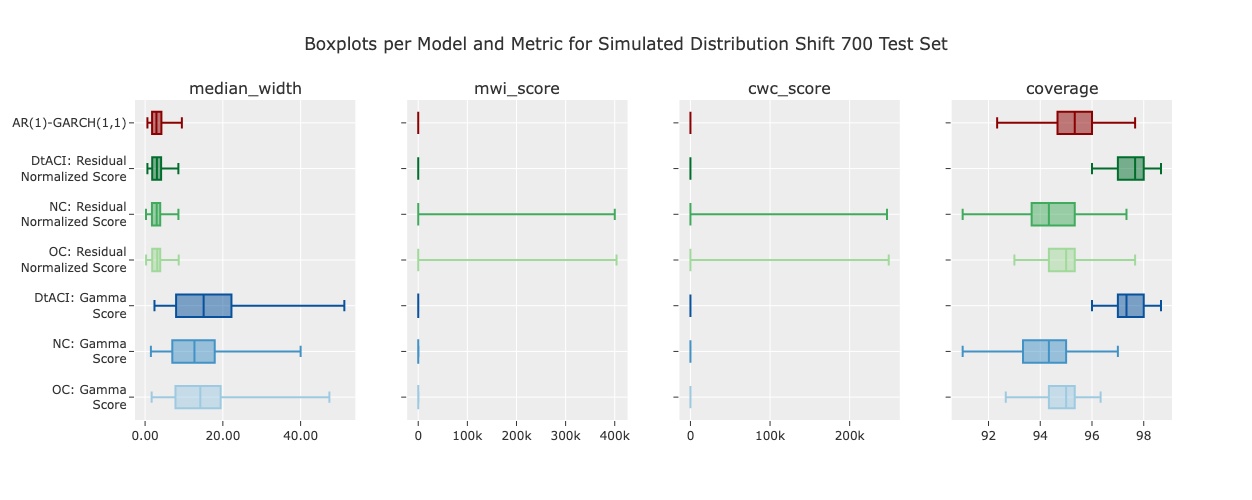

In [53]:
create_boxplots("Simulated Distribution Shift 700")

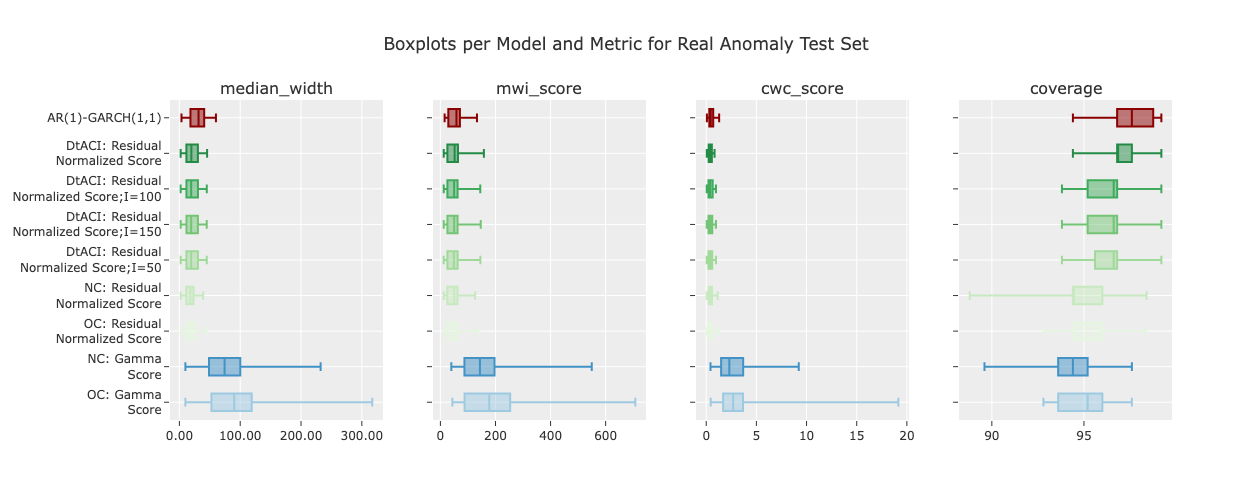

In [54]:
create_boxplots("Real Anomaly")

In [55]:
create_boxplots("Simulated Anomaly 700")

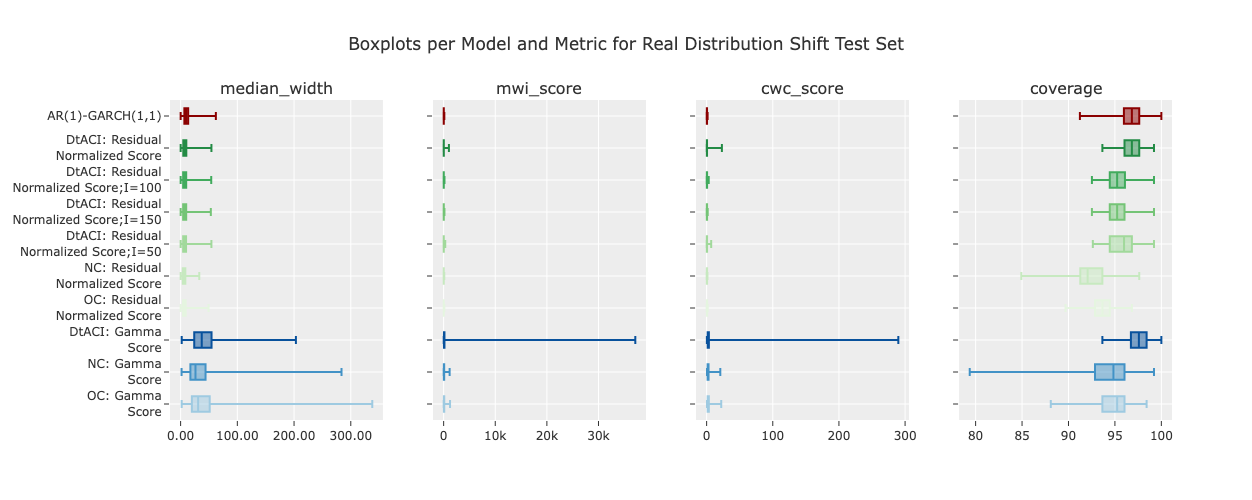

In [56]:
create_boxplots("Real Distribution Shift")

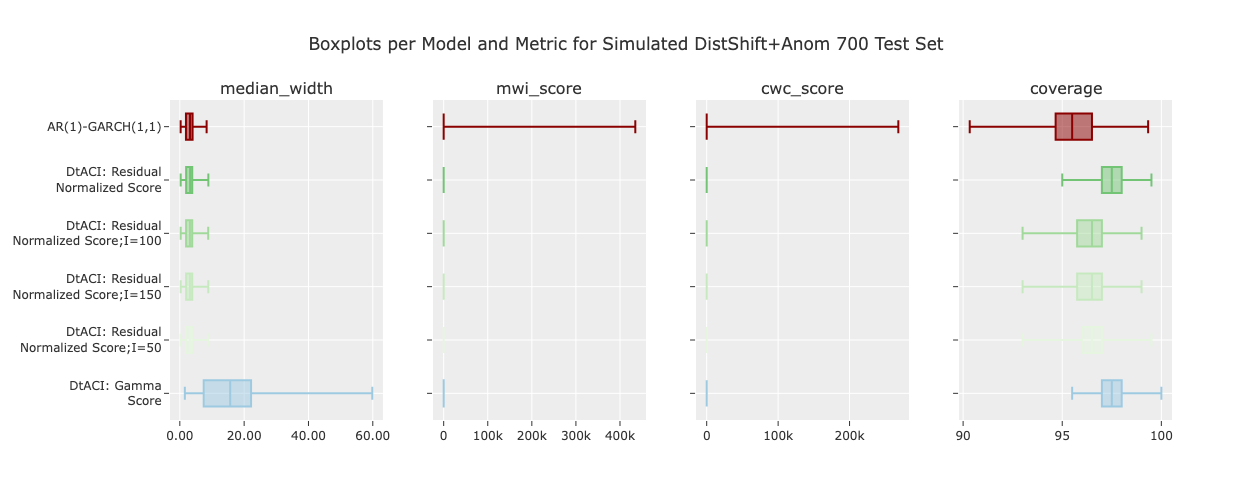

In [57]:
create_boxplots("Simulated DistShift+Anom 700")

In [8]:
import numpy as np
pd.set_option('display.float_format', '{:.3f}'.format)

test_set = "Simulated DistShift+Anom 700"
df = pd.read_sql(eval_template.format(test_set=test_set), conn)

# Extract std category from symbol, e.g. "AAPL|std=5;6" → "5;6"
df["std_category"] = df["symbol"].str.extract(r"\|std=(.*)$")

# Group by std_category and model, then compute medians
agg_df = (
    df.groupby(["std_category", "model"], as_index=False)
    .agg({
        "avg_width": "median",
        "cwc_score": "median",
        "mwi_score": "median",
        "coverage": "mean"
    })
)

# Rename columns for clarity
agg_df.rename(columns={
    "avg_width": "median_avg_width",
    "cwc_score": "median_cwc_score",
    "mwi_score": "median_mwi_score",
    "coverage": "average_coverage"
}, inplace=True)

# Display or save the result
agg_df
#Create a pivot table
pivot_table = pd.pivot_table(agg_df, values=['median_avg_width', 'median_cwc_score', 'median_mwi_score', 'average_coverage'], 
                             index='std_category', columns='model', aggfunc=np.sum, fill_value=0)
pivot_table

/var/folders/kn/522j9x8d4rv72wb61m23rshc0000gn/T/ipykernel_14769/2864025317.py:32: FutureWarning:

The provided callable <function sum at 0x10dbf5580> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



average_coverage                     \
model        AR(1)-GARCH(1,1) DtACI: Gamma Score   
std_category                                       
5;6                    95.667             97.583   
6;7                    95.933             97.567   
7;8                    95.022             97.500   
8;9                    95.733             97.450   

                                              median_avg_width  \
model        DtACI: Residual Normalized Score AR(1)-GARCH(1,1)   
std_category                                                     
5;6                                    97.383            3.231   
6;7                                    97.333            3.471   
7;8                                    97.283            3.210   
8;9                                    97.217            3.178   

                                                                  \
model        DtACI: Gamma Score DtACI: Residual Normalized Score   
std_category                                                       
5;6                      28.943                            3.251   
6;7                      24.912                            3.350   
7;8                      22.410                            3.270   
8;9                      26.430                            3.271   

             median_cwc_score                     \
model        AR(1)-GARCH(1,1) DtACI: Gamma Score   
std_category                                       
5;6                     0.670              5.067   
6;7                     0.657              5.599   
7;8                     0.688              5.339   
8;9                     0.642              4.476   

                                              median_mwi_score  \
model        DtACI: Residual Normalized Score AR(1)-GARCH(1,1)   
std_category                                                     
5;6                                     0.664            3.731   
6;7                                     0.688            4.118   
7;8                                     0.653            3.642   
8;9                                     0.667            3.665   

                                                                  
model        DtACI: Gamma Score DtACI: Residual Normalized Score  
std_category                                                      
5;6                      29.487                            3.506  
6;7                      25.310                            3.564  
7;8                      22.800                            3.479  
8;9                      26.826                            3.489

## Smaller Sample Sets

In [9]:
eval_template_small = """
    select * 
    from model_coverage_stats
    where test_set = '{test_set}'
    and (model = 'AR(1)-ARCH(1)' or base_model in ('AR(1)-ARCH(1) - 200', 'AR(1) - 200')) 
    and symbol in (
        select distinct symbol
    from argarch_results ar 
    where test_set = '{test_set}'
    group by symbol
    having count(*) >= 100
    )
    order by model
    """

In [10]:
create_boxplots(test_set="Simulated Distribution Shift 700", 
                x_columns=["median_width", "mwi_score", "cwc_score", "coverage"], eval_template = eval_template_small)

## Visualizing bands

In [12]:
import matplotlib.pyplot as plt

def plot_forecast(forecast_df, level=0.95):
    # Set the target coverage level
    target_coverage = level * 100

    # Identify points outside the confidence interval
    out_of_band = (forecast_df['actual'] < forecast_df['lower_bound']) | (forecast_df['actual'] > forecast_df['upper_bound'])
    
    # Compute empirical coverage
    coverage = 1 - out_of_band.mean()
    coverage_percent = coverage * 100

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(forecast_df['actual'], label='Actual Return', color='black', alpha=0.7)
    plt.plot(forecast_df['forecast'], label='Forecasted Mean', color='orange', linestyle='--')
    plt.fill_between(
        forecast_df.index,
        forecast_df['lower_bound'],
        forecast_df['upper_bound'],
        color='orange',
        alpha=0.2,
        label=f'{target_coverage:.1f}% CI'
    )

    # Add red dots for out-of-band points
    plt.scatter(
        forecast_df.index[out_of_band],
        forecast_df['actual'][out_of_band],
        color='red',
        label='Outside Bands',
        zorder=5
    )

    # Add coverage text (top-left corner)
    plt.text(
        0.01, 0.98,
        f'Empirical coverage: {coverage_percent:.2f}%',
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='left',
       # bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

    # Titles and legend
    plt.title(f'One-Step-Ahead Forecast with {target_coverage:.1f}% Confidence Interval')
    plt.legend()
    plt.show()

In [13]:
results_df = pd.read_sql("select * from model_coverage_stats where symbol = 'OCCI' and test_set = 'Real Distribution Shift'", conn)

In [14]:
results_df

,coverage,target_coverage,avg_width,median_width,max_width,mwi_score,cwc_score,min_width,mae,rmse,symbol,start_dt,end_dt,test_set,model,base_model
0,96.190,95.000,35.996,19.453,232.304,43.373,0.530,5.145,4.177,7.896,OCCI,2018-09-10,2020-05-20,Real Distribution Shift,"AR(1)-GARCH(1,1)",None
1,90.476,95.000,36.220,13.222,278.308,44.301,1.037,0.350,4.177,7.896,OCCI,2018-09-10,2020-05-20,Real Distribution Shift,OC: Residual Normalized Score,"AR(1)-GARCH(1,1)"
2,90.476,95.000,24.141,11.605,178.671,40.561,0.691,0.351,4.177,7.896,OCCI,2018-09-10,2020-05-20,Real Distribution Shift,NC: Residual Normalized Score,"AR(1)-GARCH(1,1)"
3,92.381,95.000,122.844,45.845,1207.617,129.411,3.522,0.058,4.304,8.058,OCCI,2018-09-10,2020-05-20,Real Distribution Shift,OC: Gamma Score,AR(1)
4,92.381,95.000,110.901,38.788,1169.582,118.223,3.179,0.058,4.304,8.058,OCCI,2018-09-10,2020-05-20,Real Distribution Shift,NC: Gamma Score,AR(1)
5,100.000,95.000,155.321,56.290,443.253,155.321,6.842,47.870,4.637,6.028,OCCI,2018-09-10,2020-05-20,Real Distribution Shift,DtACI: Gamma Score,"AR(1)-GARCH(1,1)"
6,100.000,95.000,22.315,13.483,49.714,22.315,0.983,11.744,4.637,6.028,OCCI,2018-09-10,2020-05-20,Real Distribution Shift,DtACI: Residual Normalized Score,"AR(1)-GARCH(1,1)"
7,80.000,95.000,21.929,13.653,49.122,25.334,1.864,11.836,4.637,6.028,OCCI,2018-09-10,2020-05-20,Real Distribution Shift,DtACI: Residual Normalized Score;I=100,"AR(1)-GARCH(1,1)"
8,80.000,95.000,21.801,13.627,49.027,27.121,1.853,11.815,4.637,6.028,OCCI,2018-09-10,2020-05-20,Real Distribution Shift,DtACI: Residual Normalized Score;I=50,"AR(1)-GARCH(1,1)"
9,80.000,95.000,22.028,13.657,49.199,23.832,1.872,11.841,4.637,6.028,OCCI,2018-09-10,2020-05-20,Real Distribution Shift,DtACI: Residual Normalized Score;I=150,"AR(1)-GARCH(1,1)"


In [15]:
forecast_df_1 = pd.read_sql("""
select * 
from argarch_results 
where symbol = 'CZR' 
and test_set = 'Real Distribution Shift' 
and model = 'AR(1)-GARCH(1,1)'""", 
                            conn)

In [16]:
forecast_df_1

,index,forecast,lower_bound,upper_bound,actual,within_CI,symbol,start_dt,end_dt,model,test_set
0,0,-0.065,-2.604,2.473,-0.244,1,CZR,2018-09-10,2020-05-20,"AR(1)-GARCH(1,1)",Real Distribution Shift
1,1,0.020,-2.357,2.398,0.587,1,CZR,2018-09-10,2020-05-20,"AR(1)-GARCH(1,1)",Real Distribution Shift
2,2,-0.283,-2.725,2.159,-0.574,1,CZR,2018-09-10,2020-05-20,"AR(1)-GARCH(1,1)",Real Distribution Shift
3,3,0.148,-2.223,2.520,0.078,1,CZR,2018-09-10,2020-05-20,"AR(1)-GARCH(1,1)",Real Distribution Shift
4,4,-0.097,-2.342,2.149,-0.234,1,CZR,2018-09-10,2020-05-20,"AR(1)-GARCH(1,1)",Real Distribution Shift
...,...,...,...,...,...,...,...,...,...,...,...
121,121,-0.128,-4.636,4.380,0.101,1,CZR,2018-09-10,2020-05-20,"AR(1)-GARCH(1,1)",Real Distribution Shift
122,122,-0.057,-3.928,3.814,-1.155,1,CZR,2018-09-10,2020-05-20,"AR(1)-GARCH(1,1)",Real Distribution Shift
123,123,0.382,-3.310,4.075,-1.763,1,CZR,2018-09-10,2020-05-20,"AR(1)-GARCH(1,1)",Real Distribution Shift
124,124,0.588,-3.846,5.022,1.377,1,CZR,2018-09-10,2020-05-20,"AR(1)-GARCH(1,1)",Real Distribution Shift


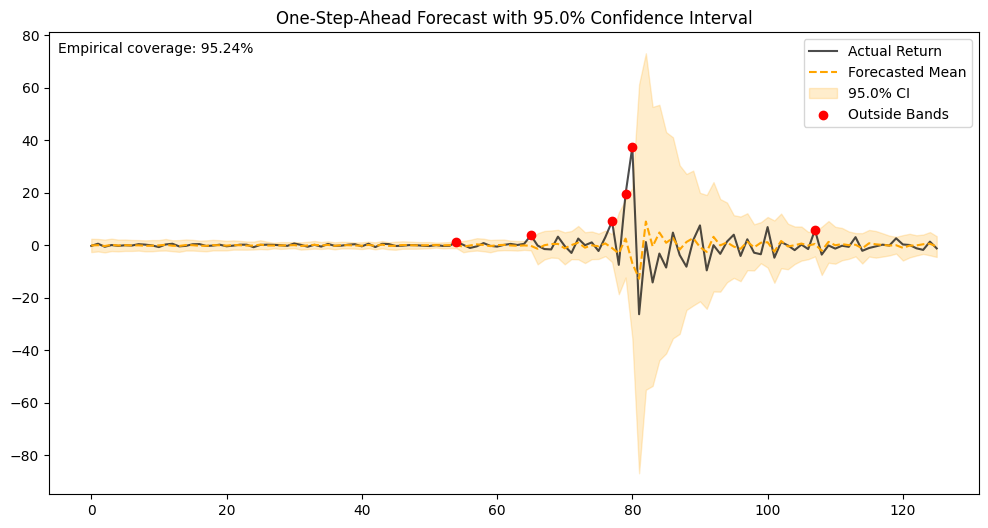

In [17]:
plot_forecast(forecast_df_1)

In [18]:
forecast_df_2 = pd.read_sql("""
select * 
from dtaci_results_new
where symbol = 'OCCI' 
and model = 'AR(1)-GARCH(1,1)'
and conformity_score = 'residual_normalized'
and test_set = 'Real Distribution Shift'""", conn)

In [19]:
forecast_df_2

,index,lower_bound,upper_bound,actual,forecast,forecast_std,alpha,within_CI,symbol,start_dt,end_dt,test_set,conformity_score,model
0,None,-6.089,7.092,-1.294,0.501,2.899,0.042,1,OCCI,2018-09-10,2020-05-20,Real Distribution Shift,residual_normalized,"AR(1)-GARCH(1,1)"
1,None,-5.377,6.367,4.511,0.495,2.655,0.043,1,OCCI,2018-09-10,2020-05-20,Real Distribution Shift,residual_normalized,"AR(1)-GARCH(1,1)"
2,None,-8.645,4.838,-1.680,-1.903,3.136,0.045,1,OCCI,2018-09-10,2020-05-20,Real Distribution Shift,residual_normalized,"AR(1)-GARCH(1,1)"
3,None,-11.114,12.336,11.944,0.611,2.784,0.014,1,OCCI,2018-09-10,2020-05-20,Real Distribution Shift,residual_normalized,"AR(1)-GARCH(1,1)"
4,None,-29.796,19.918,-10.758,-4.939,5.903,0.016,1,OCCI,2018-09-10,2020-05-20,Real Distribution Shift,residual_normalized,"AR(1)-GARCH(1,1)"


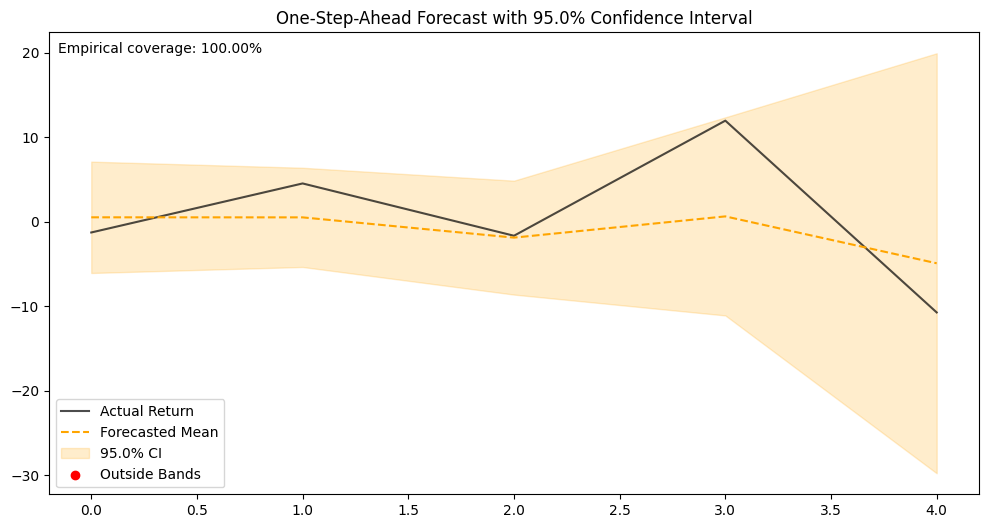

In [20]:
plot_forecast(forecast_df_2)

In [21]:
forecast_df_3= pd.read_sql("""
select * 
from dtaci_results_new
where symbol = 'CLPS' 
and model = 'AR(1)-GARCH(1,1);I=20'
and conformity_score = 'residual_normalized'
and test_set = 'Real Anomaly'""", conn)

In [22]:
# plot_forecast(forecast_df_3)

## Anomaly Evaluation

In [4]:
# anomaly dataframe
anom_df = pd.read_sql(eval_template.format(test_set="Real Anomaly"), conn)

In [5]:
query_dict = {}
for row in anom_df[["model", "base_model"]].drop_duplicates().to_numpy():
    key = row[0] + " + " + str(row[1])
    query_dict[key] = {'dataset': None, 'model': None, 'conformity_score': None, 'conformal_mode': None}

In [6]:
i = 1
for key in query_dict.keys():
    print(str(i) + f". {key}")
    i+=1

1. AR(1)-GARCH(1,1) + None
2. DtACI: Residual Normalized Score + AR(1)-GARCH(1,1)
3. DtACI: Residual Normalized Score;I=100 + AR(1)-GARCH(1,1)
4. DtACI: Residual Normalized Score;I=150 + AR(1)-GARCH(1,1)
5. DtACI: Residual Normalized Score;I=50 + AR(1)-GARCH(1,1)
6. NC: Gamma Score + AR(1)
7. NC: Residual Normalized Score + AR(1)-GARCH(1,1)
8. OC: Gamma Score + AR(1)
9. OC: Residual Normalized Score + AR(1)-GARCH(1,1)


In [7]:
# DEFINE EACH OF THESE COMBINATIONS
# 1. 'AR(1)-GARCH(1,1) + None'
query_dict['AR(1)-GARCH(1,1) + None']['dataset'] = 'argarch_results'
query_dict['AR(1)-GARCH(1,1) + None']['model'] = 'AR(1)-GARCH(1,1)'

# 2. DtACI: Residual Normalized Score + AR(1)-GARCH(1,1)
query_dict['DtACI: Residual Normalized Score + AR(1)-GARCH(1,1)']['dataset'] = 'dtaci_results_new'
query_dict['DtACI: Residual Normalized Score + AR(1)-GARCH(1,1)']['model'] = 'AR(1)-GARCH(1,1)'
query_dict['DtACI: Residual Normalized Score + AR(1)-GARCH(1,1)']['conformity_score'] = 'residual_normalized'

# 3. DtACI: Residual Normalized Score;I=100 + AR(1)-GARCH(1,1)
query_dict['DtACI: Residual Normalized Score;I=100 + AR(1)-GARCH(1,1)']['dataset'] = 'dtaci_results_new'
query_dict['DtACI: Residual Normalized Score;I=100 + AR(1)-GARCH(1,1)']['model'] = 'AR(1)-GARCH(1,1);I=100'
query_dict['DtACI: Residual Normalized Score;I=100 + AR(1)-GARCH(1,1)']['conformity_score'] = 'residual_normalized'

# 4. DtACI: Residual Normalized Score;I=150 + AR(1)-GARCH(1,1)
query_dict['DtACI: Residual Normalized Score;I=150 + AR(1)-GARCH(1,1)']['dataset'] = 'dtaci_results_new'
query_dict['DtACI: Residual Normalized Score;I=150 + AR(1)-GARCH(1,1)']['model'] = 'AR(1)-GARCH(1,1);I=150'
query_dict['DtACI: Residual Normalized Score;I=150 + AR(1)-GARCH(1,1)']['conformity_score'] = 'residual_normalized'

# 5. DtACI: Residual Normalized Score;I=50 + AR(1)-GARCH(1,1)
query_dict['DtACI: Residual Normalized Score;I=50 + AR(1)-GARCH(1,1)']['dataset'] = 'dtaci_results_new'
query_dict['DtACI: Residual Normalized Score;I=50 + AR(1)-GARCH(1,1)']['model'] = 'AR(1)-GARCH(1,1);I=50'
query_dict['DtACI: Residual Normalized Score;I=50 + AR(1)-GARCH(1,1)']['conformity_score'] = 'residual_normalized'

# 6. NC: Gamma Score + AR(1)
query_dict['NC: Gamma Score + AR(1)']['dataset'] = 'conformal_results'
query_dict['NC: Gamma Score + AR(1)']['conformal_mode'] = 'naive'
query_dict['NC: Gamma Score + AR(1)']['conformity_score'] = 'gamma'

# 7. NC: Residual Normalized Score + AR(1)-GARCH(1,1)
query_dict['NC: Residual Normalized Score + AR(1)-GARCH(1,1)']['dataset'] = 'conformal_results'
query_dict['NC: Residual Normalized Score + AR(1)-GARCH(1,1)']['conformal_mode'] = 'naive'
query_dict['NC: Residual Normalized Score + AR(1)-GARCH(1,1)']['conformity_score'] = 'residual_normalized'

# 8. OC: Gamma Score + AR(1)
query_dict['OC: Gamma Score + AR(1)']['dataset'] = 'conformal_results'
query_dict['OC: Gamma Score + AR(1)']['conformal_mode'] = 'online'
query_dict['OC: Gamma Score + AR(1)']['conformity_score'] = 'gamma'

# 9. OC: Residual Normalized Score + AR(1)-GARCH(1,1)
query_dict['OC: Residual Normalized Score + AR(1)-GARCH(1,1)']['dataset'] = 'conformal_results'
query_dict['OC: Residual Normalized Score + AR(1)-GARCH(1,1)']['conformal_mode'] = 'online'
query_dict['OC: Residual Normalized Score + AR(1)-GARCH(1,1)']['conformity_score'] = 'residual_normalized'

In [8]:
from pprint import pprint
pprint(query_dict)

{'AR(1)-GARCH(1,1) + None': {'conformal_mode': None,
                             'conformity_score': None,
                             'dataset': 'argarch_results',
                             'model': 'AR(1)-GARCH(1,1)'},
 'DtACI: Residual Normalized Score + AR(1)-GARCH(1,1)': {'conformal_mode': None,
                                                         'conformity_score': 'residual_normalized',
                                                         'dataset': 'dtaci_results_new',
                                                         'model': 'AR(1)-GARCH(1,1)'},
 'DtACI: Residual Normalized Score;I=100 + AR(1)-GARCH(1,1)': {'conformal_mode': None,
                                                               'conformity_score': 'residual_normalized',
                                                               'dataset': 'dtaci_results_new',
                                                               'model': 'AR(1)-GARCH(1,1);I=100'},
 'DtACI: Residual Normalized S

In [29]:
from data_simulator import get_reference_data
from model_fitting import ModelFitting

def get_anomaly_performance(symbol, start_dt, end_dt, model_name, conformal_mode, conformity_score, 
                            dataset, model, test_set="Real Anomaly", mkt_utils=mkt_utils):
    ref_data = get_reference_data(symbol=symbol, start_dt = start_dt, end_dt=end_dt, mkt_utils=mkt_utils)[0]

    model_query = """
        select t.* 
        from {table} t
        where test_set = '{test_set}'
        and symbol = '{symbol}'
    """
    formatted_query = model_query.format(table=dataset, test_set = test_set, symbol=symbol)
    if conformal_mode is not None:
        formatted_query += f" and conformal_mode = '{conformal_mode}'"
    if conformity_score is not None:
        formatted_query += f" and conformity_score = '{conformity_score}'"
    if model is not None:
        formatted_query += f" and model = '{model}'"
    formatted_query += " order by t.'index' asc"
    
    # get data
    model_df = pd.read_sql(formatted_query, conn)
    # print(formatted_query)
    # print(model_df)
    sub_ref_df = ref_data[-len(model_df):].reset_index(drop=True)
    model_df_dt = model_df.merge(sub_ref_df[["dlycaldt"]], left_index=True, right_index=True)

    # add in anomaly flags
    model_df_dt["anom_flag"] = 0
    
    # query real anomaly dataset
    real_anomaly_qry = """
        select *
        from manual_anomalies
        where symbol = '{symbol}'
    """
    real_anom_record = pd.read_sql(real_anomaly_qry.format(symbol=symbol), conn)
    # print(real_anom_record)

    # update anomaly flags
    model_df_dt.loc[model_df_dt['dlycaldt'].isin(real_anom_record["date"].unique()), 'anom_flag'] = 1
    # print(model_df_dt)
    
    # Find the index of the row with 1
    anom_idx = model_df_dt.index[model_df_dt['anom_flag'] == 1][0]
    
    # Split into two datasets
    before = model_df_dt.loc[:anom_idx-1]      # rows before the 1
    after = model_df_dt.loc[anom_idx + 1:]     # rows after the 1

    # create ModelFitting object
    m_fitting = ModelFitting(None)

    # get details

    # before stats
    before_stats = m_fitting.get_coverage_stats(before)
    before_stats = {f"before_{k}": v for k, v in before_stats.items()}

    # after stats
    after_stats = m_fitting.get_coverage_stats(after)
    after_stats = {f"after_{k}": v for k, v in after_stats.items()}

    # combined stats
    combined_stats = before_stats | after_stats
    
    anomaly_detected = (model_df_dt[model_df_dt['anom_flag'] == 1]['within_CI'].astype(bool) == False).all()
    band_distance = model_df.loc[anom_idx]["actual"] - model_df.loc[anom_idx]["upper_bound"]

    combined_stats["anomaly_detected"] = bool(anomaly_detected)
    combined_stats["band_distance"] = band_distance
    combined_stats["symbol"] = symbol
    combined_stats["start_dt"] = start_dt
    combined_stats["end_dt"] = end_dt
    combined_stats["model_name"] = model_name

    return combined_stats

In [30]:
from tqdm import tqdm 

anom_results = []
for ind, row in tqdm(anom_df.iterrows()):
    model_name = row['model'] + " + " + str(row['base_model'])
    anom_performance_dict = get_anomaly_performance(row['symbol'], start_dt=row['start_dt'], end_dt=row['end_dt'], model_name=model_name, 
                                                    conformal_mode = query_dict[model_name]['conformal_mode'], 
                                                    conformity_score = query_dict[model_name]['conformity_score'], 
                                                    dataset = query_dict[model_name]['dataset'], 
                                                    model = query_dict[model_name]['model'])
    anom_results.append(anom_performance_dict)

360it [01:34,  3.80it/s]


In [31]:
anom_results_df = pd.DataFrame(anom_results)

In [32]:
anom_results_df['test_set'] = 'Real Anomaly' #.columns

In [33]:
anom_results_df

,before_coverage,before_target_coverage,before_avg_width,before_median_width,before_max_width,before_mwi_score,before_cwc_score,before_min_width,before_mae,before_rmse,...,after_min_width,after_mae,after_rmse,anomaly_detected,band_distance,symbol,start_dt,end_dt,model_name,test_set
0,100.000000,95.0,5.512963,5.401799,8.147496,5.512963,1.362538,4.016255,0.581520,0.779029,...,5.570345,1.228271,4.014354,True,42.909228,BKCC,2014-04-03,2015-12-09,"AR(1)-GARCH(1,1) + None",Real Anomaly
1,97.959184,95.0,16.163172,15.046134,42.003016,19.765830,0.774129,12.968591,1.825159,2.660057,...,14.719520,2.817282,4.295439,True,9.975095,MGNX,2018-07-23,2020-03-31,"AR(1)-GARCH(1,1) + None",Real Anomaly
2,93.877551,95.0,43.614441,40.781818,83.796703,74.359382,1.253523,19.968810,7.373440,10.450585,...,32.499276,5.651790,7.707523,True,23.634111,TRIB,2018-11-06,2020-07-17,"AR(1)-GARCH(1,1) + None",Real Anomaly
3,97.959184,95.0,32.782292,28.726950,78.057332,36.900662,0.774593,17.666439,4.652415,6.340109,...,26.143915,4.905271,8.028422,True,57.310050,MRIN,2018-11-19,2020-07-30,"AR(1)-GARCH(1,1) + None",Real Anomaly
4,100.000000,95.0,13.745919,13.292553,19.328134,13.745919,1.421668,9.354287,1.637405,1.984321,...,9.238581,1.903981,2.673923,True,0.223993,NMRK,2019-05-17,2021-01-25,"AR(1)-GARCH(1,1) + None",Real Anomaly
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,95.302013,95.0,17.823367,15.469359,62.278104,20.311305,0.467590,1.946844,2.869648,3.817492,...,13.079609,3.969690,6.961179,True,58.143553,MBRX,2021-11-23,2023-08-04,"OC: Residual Normalized Score + AR(1)-GARCH(1,1)",Real Anomaly
356,92.617450,95.0,16.071028,12.266945,93.422248,32.821076,0.419077,5.251046,3.388825,6.266903,...,25.289693,9.082466,15.314546,True,116.830631,GPOR,2018-10-19,2020-06-30,"OC: Residual Normalized Score + AR(1)-GARCH(1,1)",Real Anomaly
357,93.959732,95.0,24.899871,21.445508,65.651967,38.996833,1.037430,4.193820,4.111997,6.010492,...,22.413693,5.196716,9.751389,True,50.469441,NTRP,2018-08-29,2020-05-08,"OC: Residual Normalized Score + AR(1)-GARCH(1,1)",Real Anomaly
358,94.630872,95.0,21.360280,18.272266,77.742029,29.229985,1.025073,0.987449,3.216489,4.768746,...,18.015608,5.173003,7.783992,True,25.787087,HARP,2021-07-23,2023-03-31,"OC: Residual Normalized Score + AR(1)-GARCH(1,1)",Real Anomaly


In [35]:
anom_results_df.to_sql("anomaly_results_analysis", if_exists='append', con=conn)

360

In [ ]:
# TODO: get all of the dataset combinations and run to create Sqlite table 
# get_anomaly_performance(symbol="BKCC", start_dt = "2014-04-03", end_dt="2015-12-09", test_set="Real Anomaly", results_dataset="argarch_results")

### Anomaly Results Analysis

In [37]:
anom_results_df = pd.read_sql("select * from anomaly_results_analysis", con = conn)

In [39]:
anom_results_df.columns

Index(['index', 'before_coverage', 'before_target_coverage',
       'before_avg_width', 'before_median_width', 'before_max_width',
       'before_mwi_score', 'before_cwc_score', 'before_min_width',
       'before_mae', 'before_rmse', 'after_coverage', 'after_target_coverage',
       'after_avg_width', 'after_median_width', 'after_max_width',
       'after_mwi_score', 'after_cwc_score', 'after_min_width', 'after_mae',
       'after_rmse', 'anomaly_detected', 'band_distance', 'symbol', 'start_dt',
       'end_dt', 'model_name', 'test_set'],
      dtype='object')

In [50]:
anom_results_df[[
    'model_name',
    'before_coverage', 'after_coverage',
    'before_avg_width', 'after_avg_width',
    'before_median_width', 'after_median_width',
    'before_max_width', 'after_max_width',
    'before_mwi_score', 'after_mwi_score',
    'before_cwc_score', 'after_cwc_score',
    'after_min_width'  # only after exists
]].groupby('model_name').mean()

,before_coverage,after_coverage,before_avg_width,after_avg_width,before_median_width,after_median_width,before_max_width,after_max_width,before_mwi_score,after_mwi_score,before_cwc_score,after_cwc_score,after_min_width
model_name,,,,,,,,,,,,,
"AR(1)-GARCH(1,1) + None",97.787698,98.600000,33.264658,42.010041,27.179560,32.089219,97.123637,192.676209,43.567701,46.127722,1.078336,0.788831,22.740392
"DtACI: Residual Normalized Score + AR(1)-GARCH(1,1)",97.059886,98.300000,29.607207,37.566390,21.600712,22.677181,121.660558,275.210844,38.817873,41.941131,0.843056,0.635731,12.602599
"DtACI: Residual Normalized Score;I=100 + AR(1)-GARCH(1,1)",96.106064,97.598174,27.086318,34.875647,20.242538,22.136572,103.986923,224.025734,38.181747,40.284146,0.904777,0.598085,13.051330
"DtACI: Residual Normalized Score;I=150 + AR(1)-GARCH(1,1)",96.106064,97.664840,27.267619,34.773414,20.271465,22.170475,105.268757,224.861543,38.313415,40.158153,0.908700,0.585296,13.149619
"DtACI: Residual Normalized Score;I=50 + AR(1)-GARCH(1,1)",96.004023,97.664840,26.825646,35.205425,20.120809,22.053283,102.002600,228.516975,37.883118,40.529672,0.913979,0.598044,12.667752
NC: Gamma Score + AR(1),93.139346,94.927854,141.883024,160.259883,63.198025,85.018794,1935.666279,2207.294155,149.741439,167.798102,4.627923,4.199046,1.395217
"NC: Residual Normalized Score + AR(1)-GARCH(1,1)",93.203645,96.263927,20.141839,26.358544,16.024954,19.842127,116.522922,124.454845,31.835812,34.639377,0.640348,0.577510,13.626255
OC: Gamma Score + AR(1),93.819019,95.595434,199.516060,231.993855,75.997820,115.730530,3068.325618,3349.218576,206.020042,238.563454,6.137812,5.158012,1.641988
"OC: Residual Normalized Score + AR(1)-GARCH(1,1)",93.864540,96.898174,22.508979,29.973582,17.262236,21.684841,138.100669,148.800260,32.989631,37.250228,0.722264,0.605913,14.304523


In [51]:
anom_results_df[[
    'model_name',
    'anomaly_detected', 'band_distance'  # only after exists
]].groupby('model_name').mean()

,anomaly_detected,band_distance
model_name,,
"AR(1)-GARCH(1,1) + None",0.750,21.961083
"DtACI: Residual Normalized Score + AR(1)-GARCH(1,1)",0.775,18.615904
"DtACI: Residual Normalized Score;I=100 + AR(1)-GARCH(1,1)",0.825,20.268580
"DtACI: Residual Normalized Score;I=150 + AR(1)-GARCH(1,1)",0.825,20.471657
"DtACI: Residual Normalized Score;I=50 + AR(1)-GARCH(1,1)",0.825,19.985072
NC: Gamma Score + AR(1),0.325,-44.673397
"NC: Residual Normalized Score + AR(1)-GARCH(1,1)",0.875,28.628475
OC: Gamma Score + AR(1),0.300,-80.889896
"OC: Residual Normalized Score + AR(1)-GARCH(1,1)",0.850,26.597452


### Testing on sample symbol and date range

In [17]:
ref_data = get_reference_data(symbol="BKCC", start_dt = "2014-04-03", end_dt="2015-12-09", mkt_utils=mkt_utils)[0]

In [18]:
model_query = """
select t.* 
from {table} t
where test_set = '{test_set}'
and symbol = '{symbol}'
"""
model_df = pd.read_sql(model_query.format(table="argarch_results", test_set = "Real Anomaly", symbol="BKCC"), conn)
sub_ref_df = ref_data[-len(model_df):].reset_index(drop=True)
model_df_dt = model_df.merge(sub_ref_df[["dlycaldt"]], left_index=True, right_index=True)

In [19]:
model_df_dt["anom_flag"] = 0

In [20]:
real_anomaly_qry = """
select *
from manual_anomalies
where symbol = '{symbol}'
"""
real_anom_record = pd.read_sql(real_anomaly_qry.format(symbol="BKCC"), conn)

In [21]:
model_df_dt.loc[model_df_dt['dlycaldt'].isin(real_anom_record["date"].unique()), 'anom_flag'] = 1

In [22]:
model_df_dt[model_df_dt['anom_flag'] == 1]

,index,forecast,lower_bound,upper_bound,actual,within_CI,symbol,start_dt,end_dt,model,test_set,dlycaldt,anom_flag
49,49,-1.337729,-4.5718,1.896342,44.805571,0,BKCC,2014-04-03,2015-12-09,"AR(1)-GARCH(1,1)",Real Anomaly,2015-08-24,1


In [23]:
# Find the index of the row with 1
anom_idx = model_df_dt.index[model_df_dt['anom_flag'] == 1][0]

# Split into two datasets
before = model_df_dt.loc[:anom_idx-1]      # includes the 1
after = model_df_dt.loc[anom_idx + 1:]         # rows after the 1

**Metrics**
- Stats before
- Stats after

In [24]:
from model_fitting import ModelFitting
m_fitting = ModelFitting(None)

In [25]:
model_df_dt[~model_df_dt["within_CI"].astype(bool)]

,index,forecast,lower_bound,upper_bound,actual,within_CI,symbol,start_dt,end_dt,model,test_set,dlycaldt,anom_flag
49,49,-1.337729,-4.571800,1.896342,44.805571,0,BKCC,2014-04-03,2015-12-09,"AR(1)-GARCH(1,1)",Real Anomaly,2015-08-24,1
73,73,-0.173856,-2.976052,2.628340,5.143666,0,BKCC,2014-04-03,2015-12-09,"AR(1)-GARCH(1,1)",Real Anomaly,2015-09-28,0


In [26]:
~model_df_dt["within_CI"].astype(bool)

0      False
1      False
2      False
3      False
4      False
       ...  
120    False
121    False
122    False
123    False
124    False
Name: within_CI, Length: 125, dtype: bool

In [28]:
m_fitting.get_coverage_stats(before)

{'coverage': np.float64(100.0),
 'target_coverage': 95.0,
 'avg_width': np.float64(5.512962657505867),
 'median_width': np.float64(5.401798710517279),
 'max_width': np.float64(8.14749578407118),
 'mwi_score': np.float64(5.512962657505867),
 'cwc_score': np.float64(1.3625381748800318),
 'min_width': np.float64(4.016255034010111),
 'mae': np.float64(0.5815199851753243),
 'rmse': np.float64(0.7790285842126939)}

In [29]:
m_fitting.get_coverage_stats(after)

{'coverage': np.float64(98.66666666666667),
 'target_coverage': 95.0,
 'avg_width': np.float64(19.458592365623304),
 'median_width': np.float64(7.61612097413559),
 'max_width': np.float64(230.56390584924551),
 'mwi_score': np.float64(20.800099633366226),
 'cwc_score': np.float64(0.3831507884522529),
 'min_width': np.float64(5.57034504805611),
 'mae': np.float64(1.2282706400012005),
 'rmse': np.float64(4.01435445460531)}